# Beat-Upbeat Ratio Distributions

## Import dependencies, set constants etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
import scipy.stats as stats
import statsmodels.formula.api as smf
from sklearn.mixture import GaussianMixture

from src import utils
from src.features.features_utils import FeatureExtractor
from src.visualise.bur_plots import *

C:\Python Projects\jazz-corpus-analysis\venv\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# These variables are used for the optimization process
SEED = 42
N_FOLDS = 5
N_JOBS = -1
N_BOOT = 999

In [3]:
# Upper and lower bounds to use when thresholding BURs
BUR_UPPER = 4.0
BUR_LOWER = 0.25

In [4]:
# Set the seed in NumPy for consistent results across function calls
np.random.seed(SEED)

## Load in data
We start by loading in the data we extracted from our `corpus_chronology` in `src\features\extract_features.py`. This gives us a list of `FeatureExtractor` classes (defined in `src\features\features_utils.py`).

In [5]:
features: list[FeatureExtractor] = utils.unserialise_object(fr'{utils.get_project_root()}\models\extracted_features_corpus_chronology')

In [6]:
res = []
# Iterate through each track
for track in features:
    # Iterate through each instrument
    for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
        # Iterate through each BUR by that instrument
        for bur in track.BURs[instr].bur['burs'].dropna().to_list():
            # Append a new dictionary
            res.append(dict(mbz_id=track.metadata[instr]['mbz_id'], bur=np.log2(bur), instrument=instr, tempo=track.metadata[instr]['tempo'], bandleader=track.metadata[instr]['pianist']))
burs = pd.DataFrame(res)

## Clean data
We drop BUR values lower than 0.25 and higher than 4 (see Corcoran & Frieler, 2021)

In [7]:
burs = burs[(burs['bur'] > np.log2(BUR_LOWER)) & (burs['bur'] < np.log2(BUR_UPPER))]

In [8]:
burs.groupby('instrument')['bur'].mean()

instrument
bass     0.056211
drums    0.721039
piano    0.268612
Name: bur, dtype: float64

Now we order our dataframe so that the instruments are in the correct order (piano -> bass -> drums)

In [9]:
burs = (
    burs.set_index('instrument')
    .loc[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
    .reset_index(drop=False)
)

## Plot the average BUR per instrument

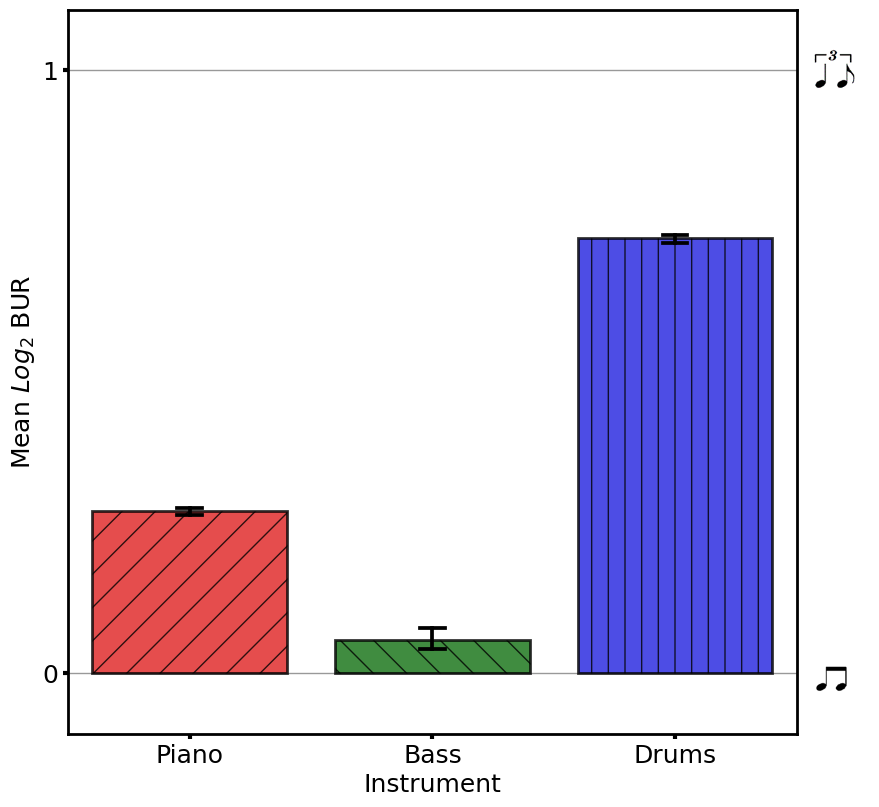

In [10]:
BarPlotBUR(burs).create_plot()
plt.show()

## Compute the KDE and extract peaks

In [11]:
def get_peaks(data, len_data: int = 1000, **kwargs) -> np.ndarray:
    """Fits a kernel-density estimate to BUR data and extracts BUR peaks"""
    # Fit the actual KDE to the data, using the default parameters
    kde = stats.gaussian_kde(data.T, bw_method='silverman')
    # Create a linear space of integers ranging from our lowest to our highest BUR
    data_plot = np.linspace(data.min(), data.max(), len_data)[:, np.newaxis]
    # Evaluate the KDE on our linear space of integers
    kde_eval = kde.evaluate(data_plot.T)
    # Find the peaks from our fitted KDE
    peaks, _ = signal.find_peaks(kde_eval, **kwargs)
    # Return the sorted peaks from our KDE: this will be an array of BUR values
    return np.sort(data_plot[peaks].flatten())

In [12]:
def bootstrap_peaks(data: np.array, actual_peaks: np.array, tol: float = 0.5) -> dict:
    """Bootstrap confidence intervals for an array of peaks"""
    # We create a dictionary with lists for storing our bootstrapped peaks
    boot_res = {pe: [] for pe in actual_peaks}
    # We perform a few operations here, so we don't have to re-do them every loop
    size = len(data)
    data = data.flatten()
    # For every bootstrapped sample
    for i_ in range(1):
        print(i_)
        # Set the random seed
        np.random.seed(i_)
        # Take a random sample of our BURs, with replacement, and reshape
        boot = np.random.choice(data, replace=True, size=size).reshape(-1, 1)
        # Get the peaks for our bootstrapped sample
        boot_peaks = set(get_peaks(boot))
        # Iterate through the actual peaks of our BURs
        for peak in actual_peaks:
            # Try and find the closest value in our bootstrapped set
            try:
                closest_peak = min(boot_peaks, key=lambda x: abs(x - peak))
            # If we've run out of bootstrapped peaks, break out and finish this sample early
            except ValueError:
                break
            else:
                # If the distance between our actual peak and the nearest bootstrapped peak exceeds our threshold
                if abs(closest_peak - peak) > tol:
                    # Then continue on to the next actual peak, without matching
                    continue
                else:
                    # Otherwise, match our actual peak with this closest peak and remove it from the set
                    boot_res[peak].append(closest_peak)
                    boot_peaks.remove(closest_peak)
    # Return a dictionary with
    return {k: [np.nanpercentile(v, 5), np.nanpercentile(v, 95)] for k, v in boot_res.items()}

In [13]:
res_ = []
for instr, grp in burs.groupby('instrument', sort=False):
    X = grp['bur'].to_numpy().reshape(-1, 1)
    grp_peaks = get_peaks(X)
    ci_peaks = bootstrap_peaks(X, grp_peaks)
    for num, (actual, (low, high)) in enumerate(ci_peaks.items()):
        res_.append(dict(
            instrument=instr,
            peak_num=num,
            peak=actual,
            low=low,
            high=high
        ))
peaks_df = pd.DataFrame(res_)

0
0
0


In [14]:
peaks_df['raw_peak'] = 2 ** peaks_df['peak']
peaks_df

,instrument,peak_num,peak,low,high,raw_peak
0,piano,0,0.334334,0.310310,0.310310,1.260796
1,bass,0,0.010515,0.018505,0.018505,1.007315
2,bass,1,1.081162,1.065182,1.065182,2.115739
3,drums,0,-0.678679,-0.678679,-0.678679,0.624737
4,drums,1,1.163163,1.167167,1.167167,2.239479


## Estimate density of distribution between peaks

In [42]:
def estimate_density(peaks, burs):
    # Peak 1
    p1 = burs[burs <= (peaks[1] + peaks[0]) / 2]
    p1_len = (len(p1) / len(burs)) * 100
    # Peak 2
    p2 = burs[burs > (peaks[1] + peaks[0]) / 2]
    p2_len = (len(p2) / len(burs)) * 100
    return p1_len, p2_len


bass_peaks = peaks_df[peaks_df['instrument'] == 'bass']['peak'].sort_values().values
bass_weight = estimate_density(
    bass_peaks,
    burs[burs['instrument'] == 'bass']['bur']
)
print(bass_weight)
drums_peaks = peaks_df[peaks_df['instrument'] == 'drums']['peak'].sort_values().values
drums_weight = estimate_density(
    drums_peaks,
    burs[burs['instrument'] == 'drums']['bur']
)
print(drums_weight)

(69.15677445763406, 30.843225542365943)
(20.82774770494307, 79.17225229505694)


In [57]:
bandleaders = pd.Series(burs['bandleader'].unique())
bandleaders_sample = [bandleaders.sample(replace=True, frac=1) for i in range(1000)]
for instr, instr_peaks in zip(['bass', 'drums'], [bass_peaks, drums_peaks]):
    boot_low, boot_high = [], []
    for n, sample in enumerate(bandleaders_sample):
        print(n)
        data = []
        for _, bandleader in sample.items():
            data.extend(burs[(burs['bandleader'] == bandleader) & (burs['instrument'] == instr)]['bur'].to_list())
        low, high = estimate_density(instr_peaks, pd.Series(data),)
        boot_low.append(low)
        boot_high.append(high)
    print(instr, 'low_peak', stats.sem(boot_low) * 1.96)
    print(instr, 'high_peak', stats.sem(boot_high) * 1.96)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## Plot the BUR distribution with density curve and peaks

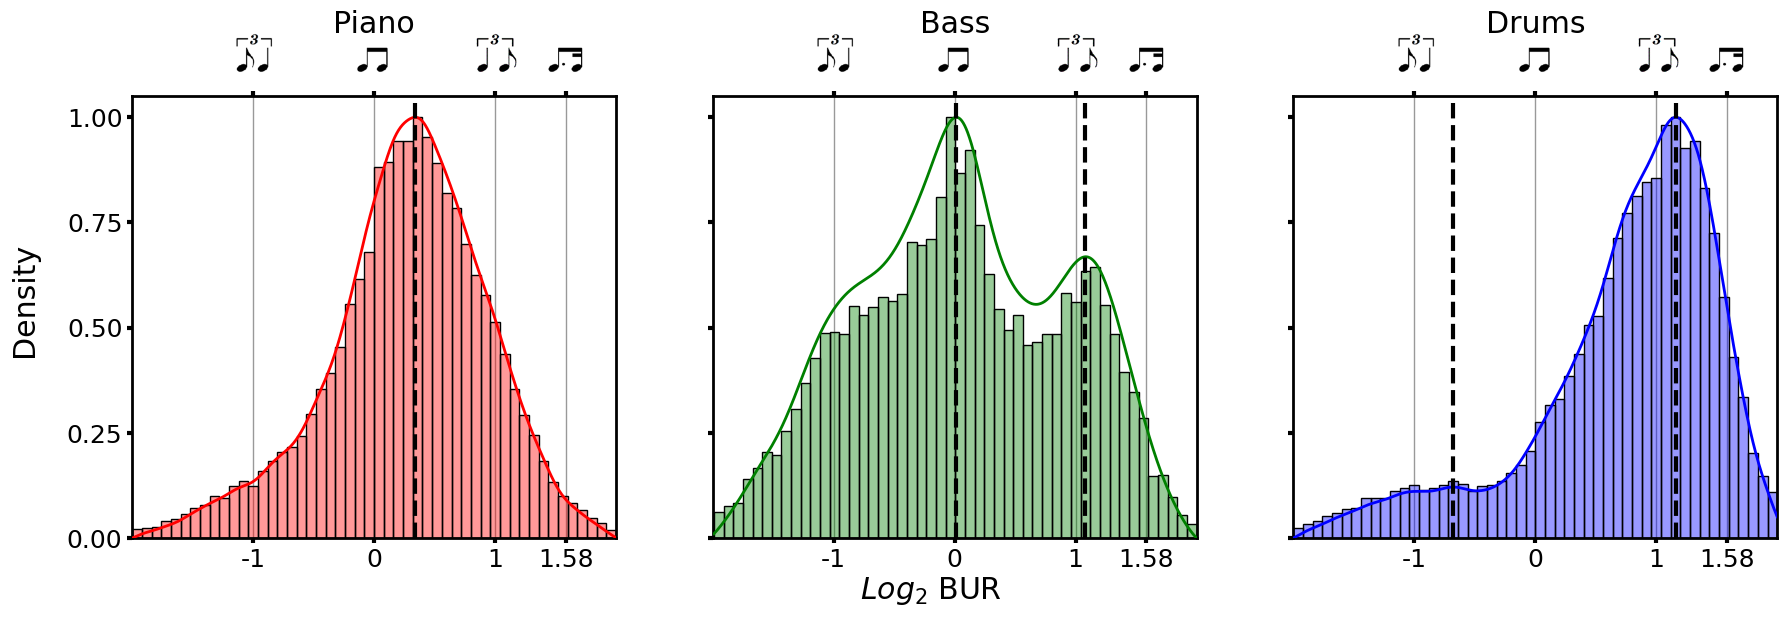

In [15]:
HistPlotBURByInstrument(burs, peaks_df).create_plot()
plt.show()

## Create GMMs using given number of components

In [16]:
for instr in ['bass', 'drums']:
    data = peaks_df[peaks_df['instrument'] == instr]
    peaks = data['peak'].to_numpy().reshape(-1, 1)
    n_components = len(data)
    gm = GaussianMixture(
        random_state=42,
        n_components=n_components,
        means_init=peaks
    )
    gm.fit(burs[burs['instrument'] == instr]['bur'].to_numpy().reshape(-1, 1))
    means = gm.means_.flatten()
    means_init = gm.means_init.flatten()
    weights = gm.weights_
    print(gm.means_.flatten(), means_init, weights)

[-0.34517166  1.04498657] [0.01051499 1.08116154] [0.71126845 0.28873155]
[-0.42768708  1.03950669] [-0.67867868  1.16316316] [0.21705932 0.78294068]


## Model average tempo vs BUR

In [17]:
average = burs.groupby(['instrument', 'mbz_id']).agg(dict(bur=['mean', 'count'], tempo='median', bandleader='first')).reset_index(drop=False)
average.columns = ['_'.join(col).strip() for col in average.columns.values]
average = average[average['bur_count'] > 15]
average['tempo_standard'] = (average['tempo_median'] - average['tempo_median'].mean()) / average['tempo_median'].std()

In [18]:
md = smf.mixedlm(
    "bur_mean~tempo_standard*C(instrument_, Treatment(reference='piano'))",
    data=average,
    groups=average['bandleader_first'],
    re_formula="0 + tempo_standard + C(instrument_, Treatment(reference='piano'))"
).fit()
print(md.summary())

                                                         Mixed Linear Model Regression Results
Model:                                             MixedLM                                 Dependent Variable:                                 bur_mean 
No. Observations:                                  751                                     Method:                                             REML     
No. Groups:                                        10                                      Scale:                                              0.0693   
Min. group size:                                   68                                      Log-Likelihood:                                     -100.8164
Max. group size:                                   81                                      Converged:                                          Yes      
Mean group size:                                   75.1                                                                                     

In [19]:
# Variance explained by the fixed effects: we need to use md.predict() with the underlying data to get this
var_fixed = md.predict().var()
# Variance explained by the random effects
var_random = float(md.cov_re.to_numpy().mean())
# Variance of the residuals
var_resid = md.scale
# Total variance of the model
total_var = var_fixed + var_random + var_resid
# Calculate the r2 values and append to the model
print('conditional_r2:', (var_fixed + var_random) / total_var)
print('marginal_r2:', var_fixed / total_var)

conditional_r2: 0.6069052210554511
marginal_r2: 0.5860129491841163


In [20]:
stddev = np.std([v.iloc[0] for v in md.random_effects.values()])
print('stdev of bandleader groups:', stddev)

stdev of bandleader groups: 0.1354858567269509


## Plot average BUR vs tempo

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


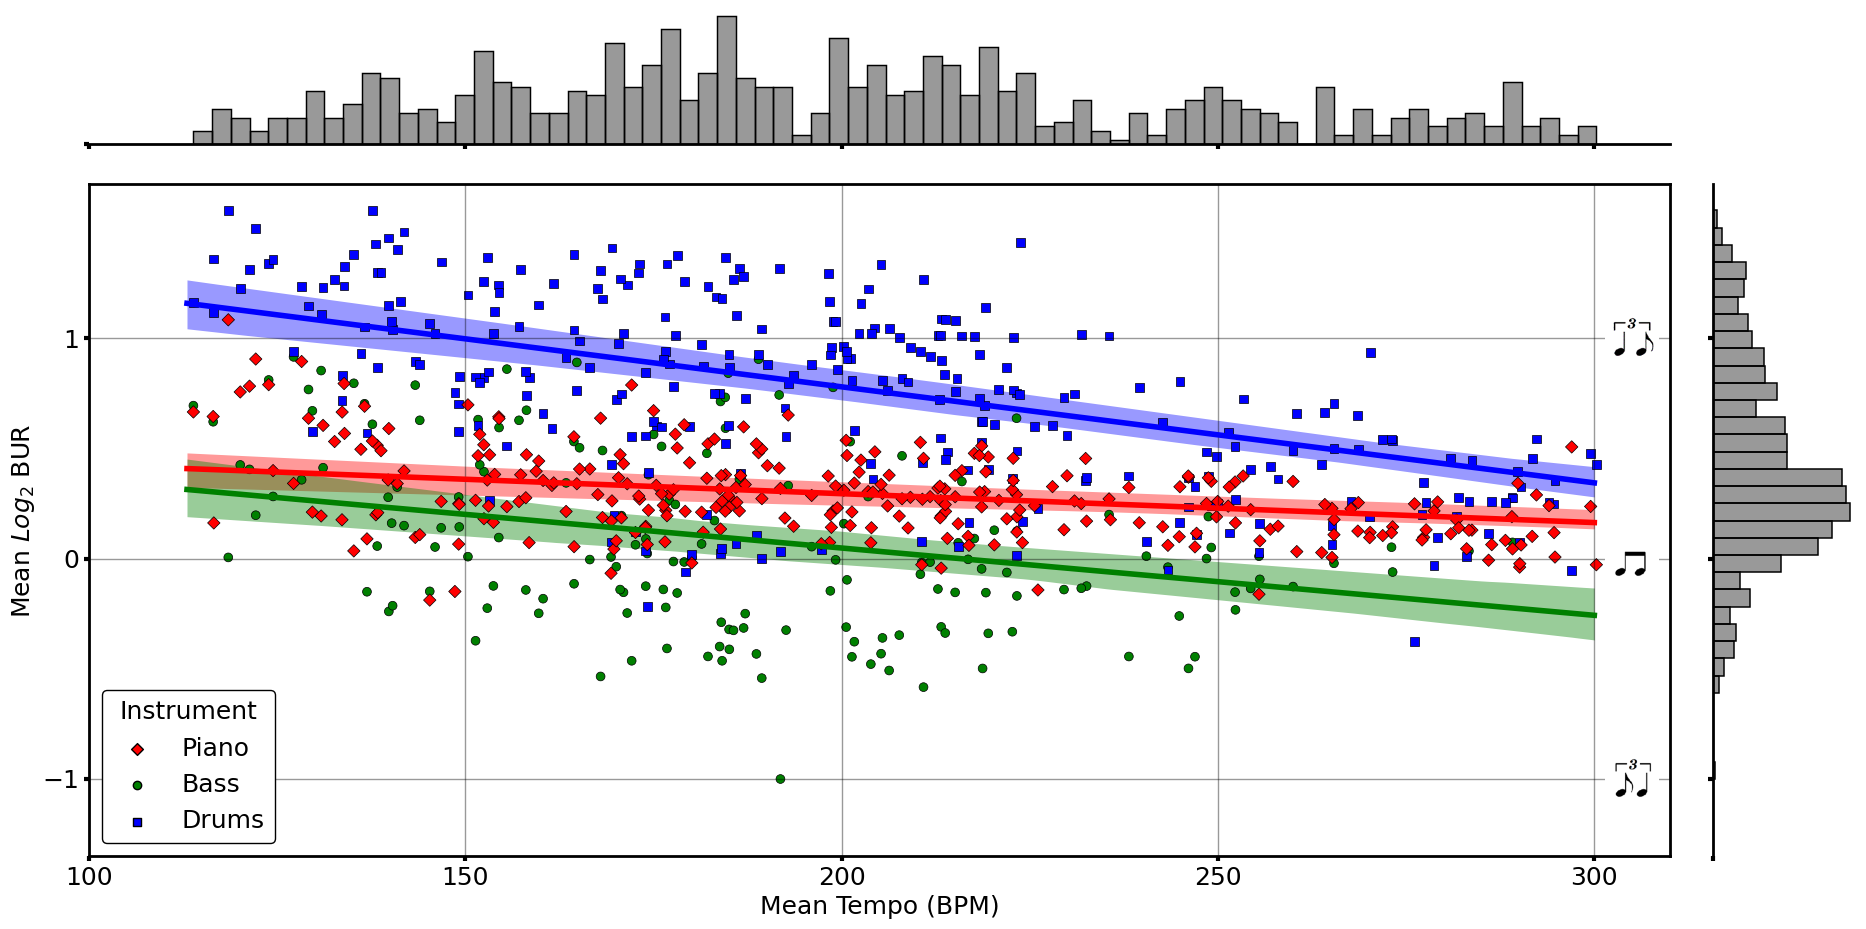

In [21]:
RegPlotBURTempo(burs).create_plot()
plt.show()